In [1]:
#!pip install -q --no-index --find-links=/kaggle/input/pip-install-lifelines lifelines
#!pip install -q --upgrade --no-index --find-links=/kaggle/input/download-xgboost-2-1-3 xgboost

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
import os, glob, math, gc, warnings, random, joblib
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
print("we are using xgboost ==", xgb.__version__)
from lightgbm import LGBMRegressor, callback

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

we are using xgboost == 2.1.1


In [2]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )


# Load Train and Test

In [4]:
DATA_DIR = 'equity-post-HCT-survival-predictions-1'


#train_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
#test_data  = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

train_data = pd.read_csv(DATA_DIR +'/train.csv')
test_data  = pd.read_csv(DATA_DIR +'/test.csv')

In [5]:
test = pd.read_csv(DATA_DIR +'/test.csv')
print("Test shape:", test.shape )

train = pd.read_csv(DATA_DIR +'/train.csv')
print("Train shape:",train.shape)

Test shape: (3, 58)
Train shape: (28800, 60)


In [6]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


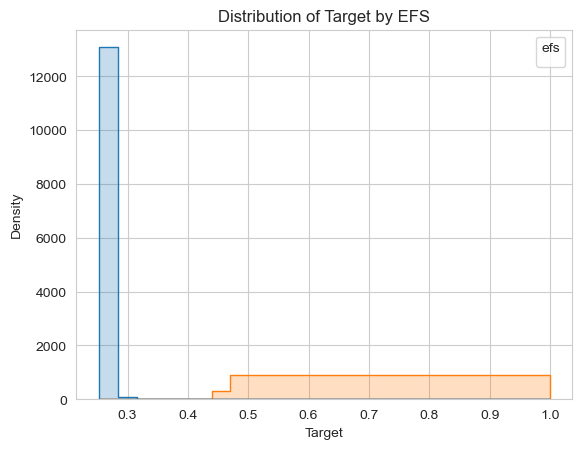

In [7]:
train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2

sns.histplot(data=train, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

In [8]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [9]:
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")

In [10]:
combined = pd.concat([train, test], axis=0, ignore_index=True)
print("The CATEGORICAL FEATURES: ",end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

The CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [11]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,label
0,0,N/A - non-malignant indication,No,NAN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NAN,6.0,2.0,No,2.0,2.0,BM,NAN,NAN,Not Hispanic or Latino,2016,No,NAN,Yes,NAN,2.0,No,NaN,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NAN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,0.258687
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,0.847759
2,2,N/A - non-malignant indication,No,NAN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NAN,NAN,Not Hispanic or Latino,2019,No,NAN,Yes,NAN,2.0,No,NaN,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,0.262424
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,0.256661
4,4,High,No,NAN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NAN,5.0,2.0,No,2.0,2.0,PB,NAN,MAC,Hispanic or Latino,2018,No,NAN,Yes,NAN,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,0.264674


In [12]:
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

# Custom Metrics

In [13]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

# XGBoost

In [15]:
%%time

oof_xgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_xgb['prediction'] = 0.0
feature_importances_xgb = pd.DataFrame()
feature_importances_xgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    # define two extra dataframe for the custom metric
    ds_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)
    
    clf = XGBRegressor(
        #tree_method="gpu_hist",
        max_depth=3,
        colsample_bytree=0.5, 
        subsample=0.8, 
        n_estimators=10000,  
        learning_rate=0.03,
        early_stopping_rounds=100,
        objective='reg:squarederror',
        enable_categorical=True,
        min_child_weight=5,
        eval_metric=CIndexMetric_XGB, # the custom metric
        disable_default_eval_metric=True # only show the custom metric
    )
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=500,
    )
    feature_importances_xgb[f'fold_{fold + 1}'] = feature_importances_xgb['feature'].map(clf.get_booster().get_score())

    preds_valid = clf.predict(x_valid)
    oof_xgb.loc[oof_xgb.kfold==fold, 'prediction'] = preds_valid

    # don't use joblib or pickle to save the model(Cannot load it)
    clf.save_model(f"xgb_model_{fold}.bin")

    y_true = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_xgb.loc[oof_xgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)

[0]	validation_0-CIndexMetric_XGB:-0.57742
[500]	validation_0-CIndexMetric_XGB:-0.65853
[1000]	validation_0-CIndexMetric_XGB:-0.66151
[1110]	validation_0-CIndexMetric_XGB:-0.66163
# c-index=0.6617, mean=0.6766 std=0.0149
[0]	validation_0-CIndexMetric_XGB:-0.58915
[500]	validation_0-CIndexMetric_XGB:-0.67389
[1000]	validation_0-CIndexMetric_XGB:-0.67968
[1500]	validation_0-CIndexMetric_XGB:-0.68131
[1634]	validation_0-CIndexMetric_XGB:-0.68130
# c-index=0.6816, mean=0.6958 std=0.0142
[0]	validation_0-CIndexMetric_XGB:-0.59866
[500]	validation_0-CIndexMetric_XGB:-0.67053
[1000]	validation_0-CIndexMetric_XGB:-0.67437
[1327]	validation_0-CIndexMetric_XGB:-0.67513
# c-index=0.6754, mean=0.6864 std=0.0110
[0]	validation_0-CIndexMetric_XGB:-0.59310
[500]	validation_0-CIndexMetric_XGB:-0.66417
[1000]	validation_0-CIndexMetric_XGB:-0.67198
[1500]	validation_0-CIndexMetric_XGB:-0.67396
[1831]	validation_0-CIndexMetric_XGB:-0.67499
# c-index=0.6750, mean=0.6883 std=0.0133
[0]	validation_0-CIndexM

In [14]:
# For inference:
# model_path = f"./xxx/xgb_model.bin"
# model = XGBRegressor()
# model.load_model(model_path)
# prediction = model.predict()

In [16]:
y_true = oof_xgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_xgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

# c-index=0.6766, mean=0.6852 std=0.0086
Overall official SCORE: 0.67656


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.7055,0.6937,0.6944,0.6882,0.6746,0.6913
Asian,0.6807,0.7219,0.6787,0.7115,0.6995,0.6984
Black or African-American,0.6666,0.6897,0.6957,0.6809,0.6638,0.6794
More than one race,0.6579,0.7055,0.6931,0.6986,0.6891,0.6888
Native Hawaiian or other Pacific Islander,0.6709,0.6791,0.6915,0.6789,0.6798,0.6800
White,0.6779,0.6848,0.6652,0.6719,0.6724,0.6744
mean,0.677,0.696,0.686,0.688,0.680,0.685
std,0.015,0.014,0.011,0.013,0.012,0.013
score,0.662,0.682,0.675,0.675,0.668,0.672


In [17]:
feature_importances_xgb['importance'] = feature_importances_xgb.drop('feature', axis=1).mean(axis=1)
feature_importances_xgb = feature_importances_xgb.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances_xgb.head(20)

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,importance
0,prim_disease_hct,576.0,946.0,725.0,1050.0,879.0,835.2
1,gvhd_proph,527.0,800.0,653.0,892.0,804.0,735.2
2,donor_age,449.0,680.0,532.0,861.0,701.0,644.6
3,dri_score,479.0,695.0,563.0,770.0,684.0,638.2
4,age_at_hct,374.0,613.0,468.0,715.0,598.0,553.6
5,year_hct,390.0,489.0,367.0,447.0,440.0,426.6
6,karnofsky_score,294.0,460.0,416.0,473.0,410.0,410.6
7,cyto_score,244.0,363.0,275.0,419.0,380.0,336.2
8,conditioning_intensity,276.0,345.0,279.0,421.0,338.0,331.8
9,comorbidity_score,244.0,342.0,275.0,413.0,350.0,324.8


## masking  feature ablation
    

In [21]:
def evaluate_feature_importance_ablation(train, FEATURES, n_folds):
    ablation_results = {}

    # Get baseline scores first
    base_scores = []
    for fold in range(n_folds):
        # Load the saved model
        model = XGBRegressor()
        model.load_model(f"xgb_model_{fold}.bin")

        # Get validation data for this fold
        x_valid = train[train.kfold == fold][FEATURES]
        y_true = train[train.kfold == fold][["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)

        # Get baseline predictions
        preds_valid = model.predict(x_valid)
        y_pred = pd.DataFrame({'ID': y_true['ID'], 'prediction': preds_valid})

        # Calculate baseline score
        base_score, _ = custom_score(y_true, y_pred, "ID", print_info=False)
        base_scores.append(base_score)

    # Now do feature ablation
    for feature in tqdm(FEATURES, desc="Evaluating features"):
        fold_impacts = []

        for fold in range(n_folds):
            # Load model for this fold
            model = XGBRegressor()
            model.load_model(f"xgb_model_{fold}.bin")

            # Get validation data and mask the feature instead of dropping it
            x_valid = train[train.kfold == fold][FEATURES].copy()
            x_valid[feature] = 0  # Neutralize the feature instead of dropping it
            y_true = train[train.kfold == fold][["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)

            # Get predictions
            preds_valid = model.predict(x_valid)
            y_pred = pd.DataFrame({'ID': y_true['ID'], 'prediction': preds_valid})

            # Calculate score without this feature
            new_score, _ = custom_score(y_true, y_pred, "ID", print_info=False)

            # Calculate impact (difference from baseline)
            impact = base_scores[fold] - new_score
            fold_impacts.append(impact)

        # Store average impact across folds
        ablation_results[feature] = np.mean(fold_impacts)

    # Convert to DataFrame and sort by importance
    ablation_df = pd.DataFrame({
        'feature': list(ablation_results.keys()),
        'importance': list(ablation_results.values())
    })
    ablation_df = ablation_df.sort_values('importance', ascending=False).reset_index(drop=True)

    return ablation_df

# Run the analysis with timing
import time
start_time = time.time()
feature_ablation_df = evaluate_feature_importance_ablation(train, FEATURES, skf.n_splits)
end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

# Display top 20 most important features
print("\nTop 20 most important features by ablation analysis:")
print(feature_ablation_df.head(20))

Evaluating features: 100%|██████████| 57/57 [00:37<00:00,  1.53it/s]

Time taken: 38.17 seconds

Top 20 most important features by ablation analysis:
                   feature  importance
0   conditioning_intensity    0.013932
1                dri_score    0.011703
2          karnofsky_score    0.010980
3                 year_hct    0.010546
4         prim_disease_hct    0.007121
5               gvhd_proph    0.005909
6        comorbidity_score    0.005319
7               hla_nmdp_6    0.005150
8               age_at_hct    0.005039
9              in_vivo_tcd    0.004385
10               sex_match    0.004160
11         hla_match_b_low    0.004147
12               donor_age    0.003623
13        hla_match_b_high    0.003367
14       cyto_score_detail    0.003217
15     hla_match_dqb1_high    0.002862
16               vent_hist    0.002838
17                 mrd_hct    0.002809
18        hla_match_a_high    0.002555
19             pulm_severe    0.002475


## real ablation    

In [22]:
# After your existing code completes, run this ablation analysis
def run_ablation_analysis():
    base_score = oof_xgb['prediction'].copy()  # Save original predictions
    ablation_results = []

    # For each feature
    for feature in FEATURES:
        oof_ablation = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
        oof_ablation['prediction'] = 0.0
        features_subset = [f for f in FEATURES if f != feature]  # Remove the feature

        fold_metrics = []
        # Retrain model for each fold without this feature
        for fold in range(skf.n_splits):
            x_train = train[train.kfold != fold].copy()
            x_valid = train[train.kfold == fold].copy()

            y_train = x_train['label']
            y_valid = x_valid['label']

            x_train = x_train[features_subset]
            x_valid = x_valid[features_subset]

            ds_true = oof_ablation.loc[oof_ablation.kfold==fold,
            ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
            ds_pred = oof_ablation.loc[oof_ablation.kfold==fold,
            ["ID"]].copy().reset_index(drop=True)

            clf = XGBRegressor(
                max_depth=3,
                colsample_bytree=0.5,
                subsample=0.8,
                n_estimators=10000,
                learning_rate=0.03,
                early_stopping_rounds=100,
                objective='reg:squarederror',
                enable_categorical=True,
                min_child_weight=5,
                eval_metric=CIndexMetric_XGB,
                disable_default_eval_metric=True
            )

            clf.fit(
                x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                verbose=0
            )

            preds_valid = clf.predict(x_valid)
            oof_ablation.loc[oof_ablation.kfold==fold, 'prediction'] = preds_valid

            y_true = oof_ablation.loc[oof_ablation.kfold==fold,
            ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
            y_pred = oof_ablation.loc[oof_ablation.kfold==fold,
            ["ID","prediction"]].copy().reset_index(drop=True)

            m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=False)
            fold_metrics.append(m)

        # Calculate importance as difference from original score
        avg_ablated_score = np.mean(fold_metrics)
        original_score = np.mean([custom_score(
            oof_xgb.loc[oof_xgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True),
            oof_xgb.loc[oof_xgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True),
            "ID", print_info=False)[0] for fold in range(skf.n_splits)])

        importance = original_score - avg_ablated_score

        ablation_results.append({
            'feature': feature,
            'importance': importance,
            'ablated_score': avg_ablated_score,
            'original_score': original_score
        })

        print(f"Completed ablation for {feature}: importance = {importance:.6f}")

    return pd.DataFrame(ablation_results).sort_values('importance', ascending=False)

# Run the ablation analysis
ablation_results_df = run_ablation_analysis()
print("\nTop 20 most important features by ablation analysis:")
print(ablation_results_df.head(20))

Completed ablation for dri_score: importance = 0.047612
Completed ablation for psych_disturb: importance = 0.050642
Completed ablation for cyto_score: importance = 0.051021
Completed ablation for diabetes: importance = 0.050840
Completed ablation for hla_match_c_high: importance = 0.050933
Completed ablation for hla_high_res_8: importance = 0.050813
Completed ablation for tbi_status: importance = 0.051048
Completed ablation for arrhythmia: importance = 0.050983
Completed ablation for hla_low_res_6: importance = 0.051161
Completed ablation for graft_type: importance = 0.051291
Completed ablation for vent_hist: importance = 0.051363
Completed ablation for renal_issue: importance = 0.051170
Completed ablation for pulm_severe: importance = 0.051497
Completed ablation for prim_disease_hct: importance = 0.056622
Completed ablation for hla_high_res_6: importance = 0.051295
Completed ablation for cmv_status: importance = 0.051859
Completed ablation for hla_high_res_10: importance = 0.051342
Co